In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import re
from matplotlib import pyplot as plt

import params
from components import PrismaticLens
from utils.xrtutils import get_minmax
import xrt.backends.raycing.materials as rm
from IPython.display import display, HTML

In [2]:
mBeryllium = rm.Material('Be', rho=1.848, kind='lens')
mAl = rm.Material('Al', rho=2.7, kind='lens')
mDiamond = rm.Material('C', rho=3.5, kind='lens')
mGraphite = rm.Material('C', rho=2.15, kind='lens')

fdist = 25.8e3  # mm
ens = np.array([30., 35., 40.]) * 1.e3 # eV
optimal_geometry = pd.DataFrame(
    columns=pd.MultiIndex.from_product([['Be', 'Al', 'Gr'], ['y_t [mm]', 'L [mm]', 'Apt [mm]']]),
)
optimal_geometry['E [keV]'] = (ens * 1e-3).astype(int)
optimal_geometry = optimal_geometry.set_index('E [keV]')
optimal_geometry = optimal_geometry.sort_index(axis=1)

for mat, cpt in zip((mBeryllium, mAl, mGraphite), ('Be', 'Al', 'Gr')):
    for en_ in ens:
        opt_pars = PrismaticLens.calc_optimal_params(mat, fdist, en_)
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'y_t [mm]')] = opt_pars['y_t']
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'L [mm]')] = opt_pars['L']
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'Apt [mm]')] = opt_pars['Aperture']

fixed_geometry = pd.DataFrame(index=['Be', 'Al', 'Gr'], columns=['y_t [mm]', 'L [mm]'])
for m_name in ['Be', 'Al', 'Gr']:
    fixed_geometry.loc[m_name, 'y_t [mm]'] = np.round(np.max(optimal_geometry.loc[:, (m_name, 'y_t [mm]')]), decimals=2)
    fixed_geometry.loc[m_name, 'L [mm]'] = int(np.round(np.max(optimal_geometry.loc[:, (m_name, 'L [mm]')]), decimals=0))

display(HTML('<center><h1>Lens param optimization</h1></center>'))
display(optimal_geometry)
display(fixed_geometry)

Al                             Be                       \
         Apt [mm]     L [mm]  y_t [mm]  Apt [mm]     L [mm]  y_t [mm]   
E [keV]                                                                 
30       1.359426   8.929917  0.371576  3.271974  82.242216  0.894339   
35       1.407179  13.030645  0.384629  2.873429  86.333604  0.785404   
40       1.432371   17.64132  0.391515  2.558494   89.40025  0.699322   

               Gr                       
         Apt [mm]     L [mm]  y_t [mm]  
E [keV]                                 
30       2.876123  48.519463   0.78614  
35       2.620122  54.811442  0.716167  
40       2.389266  59.533857  0.653066

,y_t [mm],L [mm]
Be,0.89,89
Al,0.39,18
Gr,0.79,60


0.14218750000000005
0.13125
1.0171875


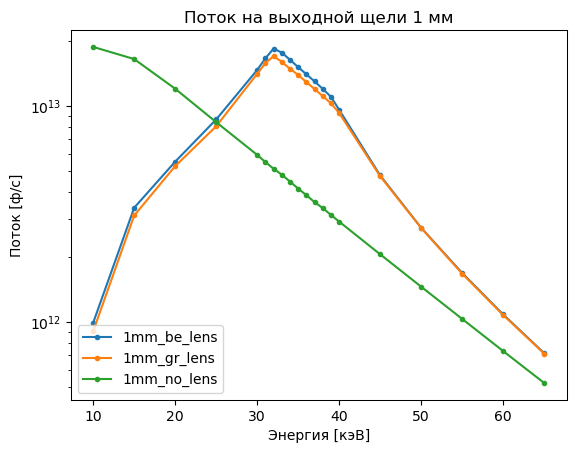

In [6]:
for dd in ["1mm_be_lens", "1mm_gr_lens", "1mm_no_lens"]:
    dd = os.path.join(os.getenv("BASE_DIR", ""), "datasets", "skif13", dd)

    ens, ws, flux = [], [], []
    for fname in sorted(filter(lambda x: x.endswith('.pickle') and x.startswith('Sample Monitor'), os.listdir(dd))):
        mtc = re.match(r'[\w ]+ \[(?P<pos>[\w\d\. ]+)\] \[(?P<en>[\w\d\. ]+)\].pickle', fname)
        ens.append(float(mtc.groupdict()['en'].split(' ')[0]))
        with open(os.path.join(dd, fname), 'rb') as f:
            data = pickle.load(f)
            flux.append(data.flux)
            mm = get_minmax(data, 'y', fadeout=5e-2)
            ws.append(mm[1] - mm[0])
    print(min(ws))

    ens, ws, flux = np.array(ens), np.array(ws), np.array(flux)
    plt.semilogy(ens, flux, linestyle='-', marker='.', label=os.path.basename(dd))
plt.xlabel('Энергия [кэВ]')
plt.ylabel('Поток [ф/с]')
plt.title('Поток на выходной щели 1 мм')
plt.legend(loc='lower left')
plt.show()